In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score,precision_score,recall_score
import plotly.express as px

In [2]:
data = pd.read_csv("/content/final_dataset_with_et.csv")

In [3]:
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)
data = data[data['Gs'] > 0]
data['NETRAD'] = data['NETRAD'].replace(-9999, np.nan)
data['NETRAD'].fillna(method='ffill', inplace=True)
data['NETRAD'].fillna(method='bfill', inplace=True)
data = data.dropna()
if data.isnull().any().any():
    print("Warning: Missing values still exist.")
else:
    print("No missing values detected.")

No missing values detected.


<ipython-input-3-089eae31e410>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-089eae31e410>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)
<ipython-input-3-089eae31e410>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['NETRAD'].fillna(me

In [ ]:
data.shape

(4016, 18)

In [ ]:
variables_to_plot = ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F', 'NDVI', 'NIRv', 'NETRAD']

# Plot each variable
for var in variables_to_plot:
    fig = px.line(data, x='TIMESTAMP', y=var, title=f'Time Series Plot of {var}',
                  labels={'TIMESTAMP': 'Timestamp', var: var})
    fig.show()

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming `data` is a pandas DataFrame with relevant columns
data['ET'].dropna()

# Prepare feature and target sets
features = data[['TA_F', 'P_F', 'SW_IN_F', 'VPD_F', 'NDVI', 'NIRv']]
target = np.log(data['Gs'])  # Applying log transformation on target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM: [samples, time steps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to calculate AIC
def calculate_aic(n, mse, k):
    return n * np.log(mse) + 2 * k

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Hyperparameter tuning setup
best_params = None
best_aic = float('inf')
best_model = None

lstm_units_list = [32, 64, 128]
dense_units_list = [16, 32, 64]
batch_sizes = [16, 32]

# Nested loop for hyperparameter tuning
for lstm_units in lstm_units_list:
    for dense_units in dense_units_list:
        for batch_size in batch_sizes:
            print(f"Testing LSTM Units: {lstm_units}, Dense Units: {dense_units}, Batch Size: {batch_size}")

            # Define the model with current hyperparameters
            def create_lstm_model(input_shape, lstm_units, dense_units):
                model = Sequential()
                model.add(LSTM(lstm_units, activation='relu', input_shape=input_shape))
                model.add(Dense(dense_units, activation='relu'))
                model.add(Dense(1))
                return model

            lstm_model = create_lstm_model(
                (X_train_reshaped.shape[1], X_train_reshaped.shape[2]),
                lstm_units,
                dense_units
            )
            lstm_model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            history = lstm_model.fit(
                X_train_reshaped, y_train,
                epochs=100,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )

            # Evaluate the model
            lstm_predictions = lstm_model.predict(X_test_reshaped).flatten()
            mse = mean_squared_error(y_test, lstm_predictions)
            n = X_test_reshaped.shape[0]  # Number of observations
            k = lstm_model.count_params()  # Number of model parameters

            # Calculate AIC
            aic = calculate_aic(n, mse, k)
            print(f"AIC: {aic:.4f}, MSE: {mse:.4f}, Parameters: {k}")

            # Save the best model
            if aic < best_aic:
                best_aic = aic
                best_params = (lstm_units, dense_units, batch_size)
                best_model = lstm_model

print(f"Best Parameters: LSTM Units: {best_params[0]}, Dense Units: {best_params[1]}, Batch Size: {best_params[2]}")
print(f"Best AIC: {best_aic:.4f}")

# Evaluate the best model on test data
lstm_predictions = best_model.predict(X_test_reshaped).flatten()
mse = mean_squared_error(y_test, lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions)
r2 = r2_score(y_test, lstm_predictions)

print(f'LSTM Model Metrics:')
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')



Testing LSTM Units: 32, Dense Units: 16, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 9941.9202, MSE: 0.2446, Parameters: 5537
Testing LSTM Units: 32, Dense Units: 16, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 11490.2533, MSE: 1.6782, Parameters: 5537
Testing LSTM Units: 32, Dense Units: 32, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 12072.2772, MSE: 0.8944, Parameters: 6081
Testing LSTM Units: 32, Dense Units: 32, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AIC: 12385.4712, MSE: 1.3204, Parameters: 6081
Testing LSTM Units: 32, Dense Units: 64, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 14108.2915, MSE: 0.7515, Parameters: 7169
Testing LSTM Units: 32, Dense Units: 64, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AIC: 14410.8842, MSE: 1.0949, Parameters: 7169
Testing LSTM Units: 64, Dense Units: 16, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 38258.8884, MSE: 0.7729, Parameters: 19233
Testing LSTM Units: 64, Dense Units: 16, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 38991.9301, MSE: 1.9235, Parameters: 19233
Testing LSTM Units: 64, Dense Units: 32, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 40411.2702, MSE: 0.8127, Parameters: 20289
Testing LSTM Units: 64, Dense Units: 32, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 40721.2081, MSE: 1.1950, Parameters: 20289
Testing LSTM Units: 64, Dense Units: 64, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 44440.6994, MSE: 0.6380, Parameters: 22401
Testing LSTM Units: 64, Dense Units: 64, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AIC: 44754.5355, MSE: 0.9427, Parameters: 22401
Testing LSTM Units: 128, Dense Units: 16, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 142130.1906, MSE: 0.7131, Parameters: 71201
Testing LSTM Units: 128, Dense Units: 16, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 142700.5622, MSE: 1.4497, Parameters: 71201
Testing LSTM Units: 128, Dense Units: 32, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AIC: 146274.7352, MSE: 0.6996, Parameters: 73281
Testing LSTM Units: 128, Dense Units: 32, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 146749.7463, MSE: 1.2630, Parameters: 73281
Testing LSTM Units: 128, Dense Units: 64, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AIC: 154463.5637, MSE: 0.5943, Parameters: 77441
Testing LSTM Units: 128, Dense Units: 64, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 154831.6292, MSE: 0.9393, Parameters: 77441
Best Parameters: LSTM Units: 32, Dense Units: 16, Batch Size: 16
Best AIC: 9941.9202
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Metrics:
MSE: 0.2446, RMSE: 0.4946, MAE: 0.2492, R²: 0.8943


Testing LSTM Units: 32, Dense Units: 16, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
AIC: 10997.8515, MSE: 0.9096, Parameters: 5537
Testing LSTM Units: 32, Dense Units: 16, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AIC: 11691.2064, MSE: 2.1547, Parameters: 5537
Testing LSTM Units: 32, Dense Units: 32, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 12097.0135, MSE: 0.9224, Parameters: 6081
Testing LSTM Units: 32, Dense Units: 32, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AIC: 12297.0727, MSE: 1.1829, Parameters: 6081
Testing LSTM Units: 32, Dense Units: 64, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
AIC: 14049.0672, MSE: 0.6981, Parameters: 7169
Testing LSTM Units: 32, Dense Units: 64, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AIC: 14427.2865, MSE: 1.1175, Parameters: 7169
Testing LSTM Units: 64, Dense Units: 16, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 38231.0535, MSE: 0.7466, Parameters: 19233
Testing LSTM Units: 64, Dense Units: 16, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 38934.6998, MSE: 1.7913, Parameters: 19233
Testing LSTM Units: 64, Dense Units: 32, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 40383.7382, MSE: 0.7854, Parameters: 20289
Testing LSTM Units: 64, Dense Units: 32, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AIC: 40823.5675, MSE: 1.3572, Parameters: 20289
Testing LSTM Units: 64, Dense Units: 64, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
AIC: 44441.9788, MSE: 0.6390, Parameters: 22401
Testing LSTM Units: 64, Dense Units: 64, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 44907.4702, MSE: 1.1402, Parameters: 22401
Testing LSTM Units: 128, Dense Units: 16, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AIC: 142136.1984, MSE: 0.7185, Parameters: 71201
Testing LSTM Units: 128, Dense Units: 16, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 142551.0818, MSE: 1.2037, Parameters: 71201
Testing LSTM Units: 128, Dense Units: 32, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
AIC: 146199.5035, MSE: 0.6371, Parameters: 73281
Testing LSTM Units: 128, Dense Units: 32, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 146535.6523, MSE: 0.9678, Parameters: 73281
Testing LSTM Units: 128, Dense Units: 64, Batch Size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AIC: 154449.0471, MSE: 0.5836, Parameters: 77441
Testing LSTM Units: 128, Dense Units: 64, Batch Size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AIC: 154741.1279, MSE: 0.8393, Parameters: 77441


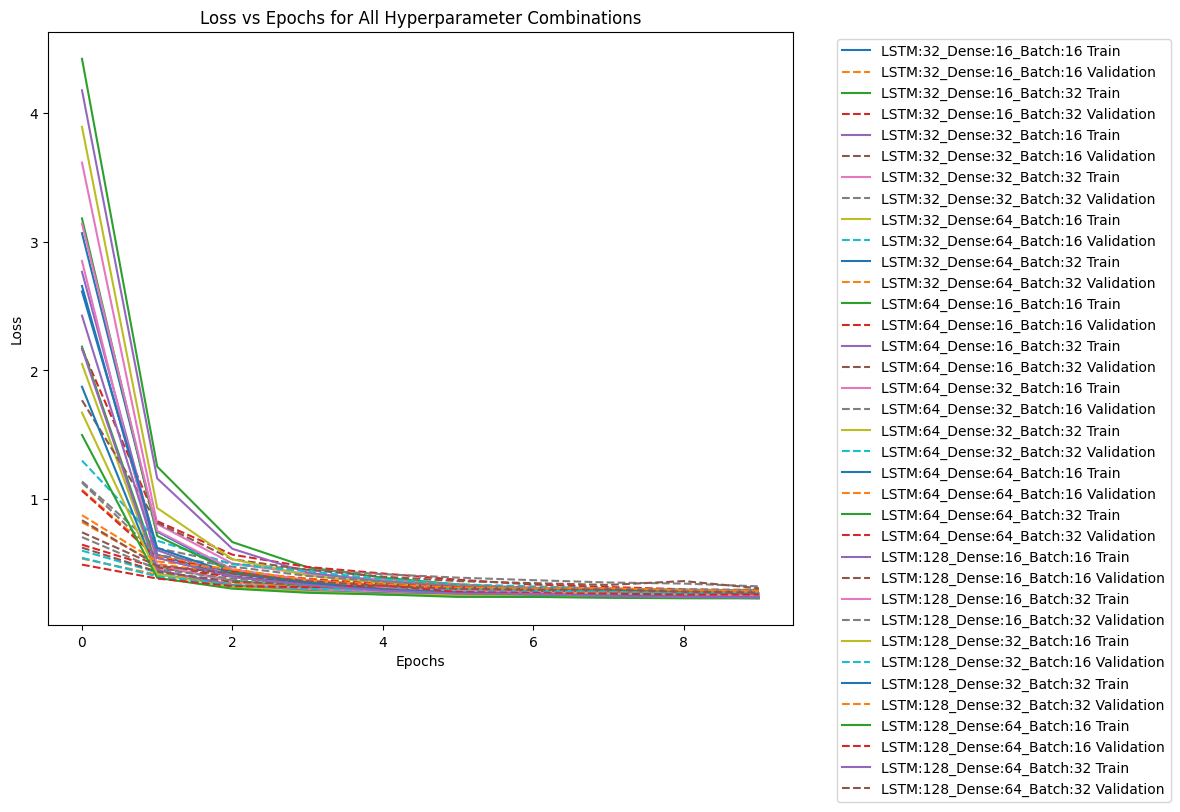

In [5]:
import matplotlib.pyplot as plt

# Dictionary to store history for each combination
history_dict = {}

for lstm_units in lstm_units_list:
    for dense_units in dense_units_list:
        for batch_size in batch_sizes:
            print(f"Testing LSTM Units: {lstm_units}, Dense Units: {dense_units}, Batch Size: {batch_size}")

            # Define the model with current hyperparameters
            lstm_model = create_lstm_model(
                (X_train_reshaped.shape[1], X_train_reshaped.shape[2]),
                lstm_units,
                dense_units
            )
            lstm_model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model and log history
            history = lstm_model.fit(
                X_train_reshaped, y_train,
                epochs=100,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=[early_stopping, reduce_lr],
                verbose=0
            )

            # Save training history
            combination_key = f"LSTM:{lstm_units}_Dense:{dense_units}_Batch:{batch_size}"
            history_dict[combination_key] = history.history

            # Evaluate the model
            lstm_predictions = lstm_model.predict(X_test_reshaped).flatten()
            mse = mean_squared_error(y_test, lstm_predictions)
            n = X_test_reshaped.shape[0]  # Number of observations
            k = lstm_model.count_params()  # Number of model parameters

            # Calculate AIC
            aic = calculate_aic(n, mse, k)
            print(f"AIC: {aic:.4f}, MSE: {mse:.4f}, Parameters: {k}")

            # Save the best model
            if aic < best_aic:
                best_aic = aic
                best_params = (lstm_units, dense_units, batch_size)
                best_model = lstm_model

# Plot the training and validation loss for all combinations
plt.figure(figsize=(12, 8))
for key, hist in history_dict.items():
    plt.plot(hist['loss'], label=f"{key} Train")
    plt.plot(hist['val_loss'], label=f"{key} Validation", linestyle='--')

plt.title('Loss vs Epochs for All Hyperparameter Combinations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


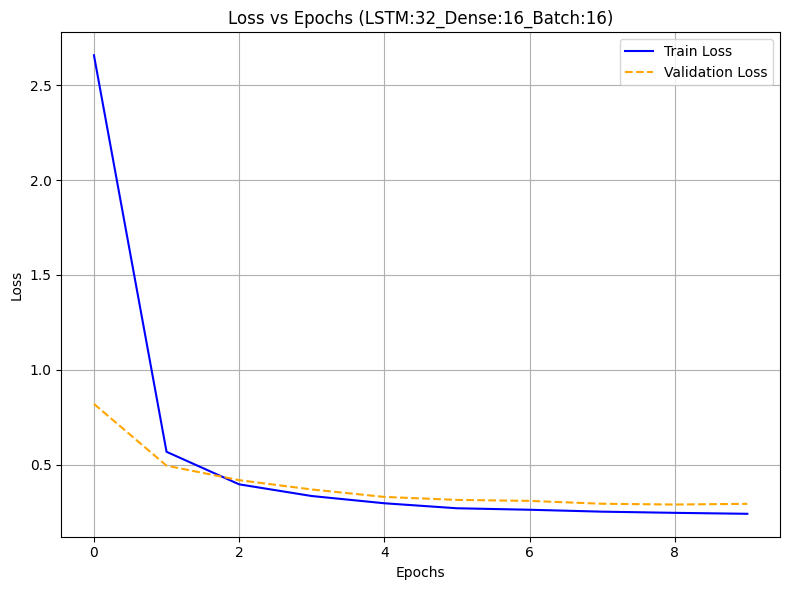

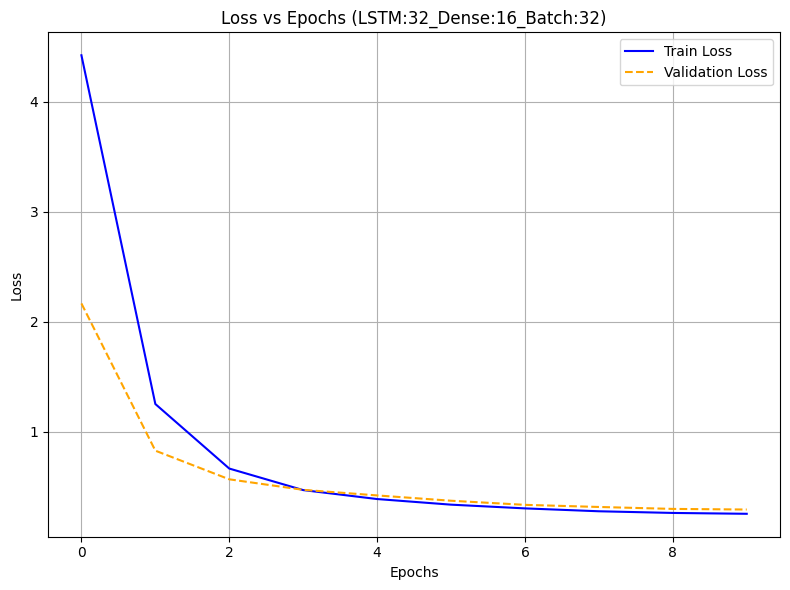

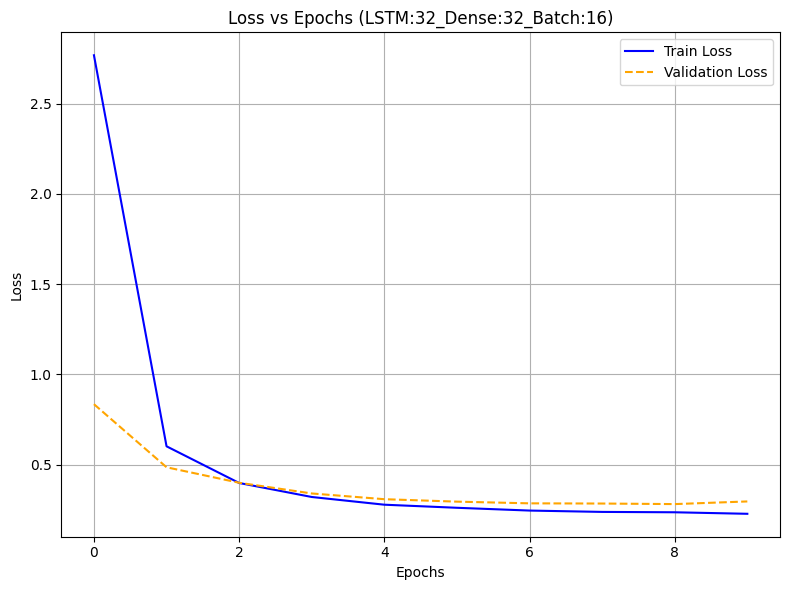

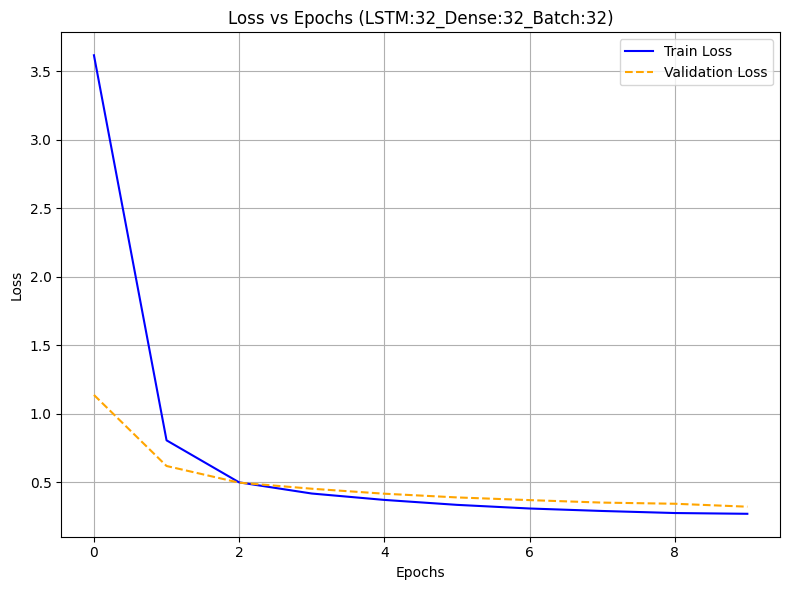

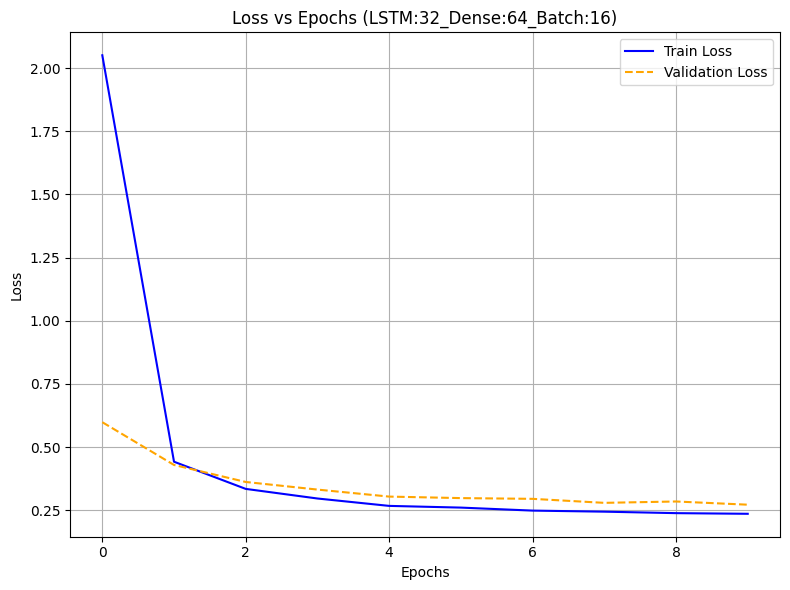

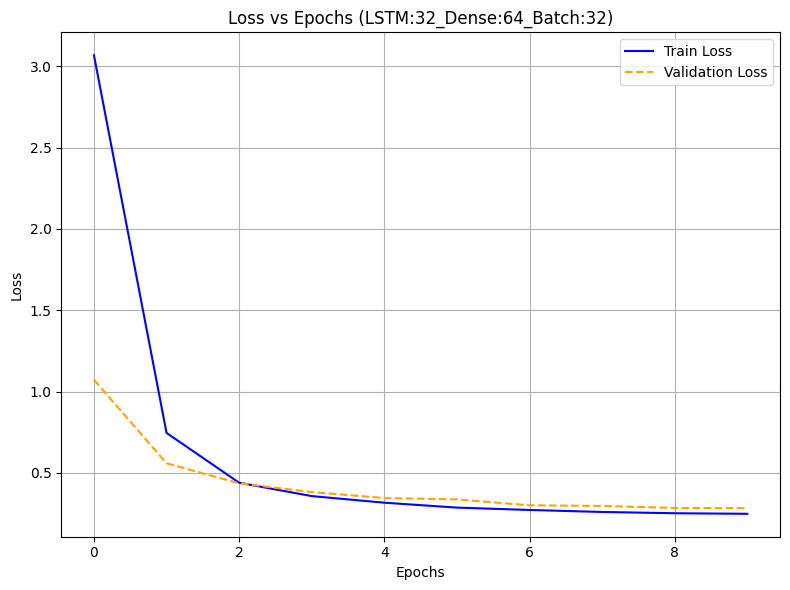

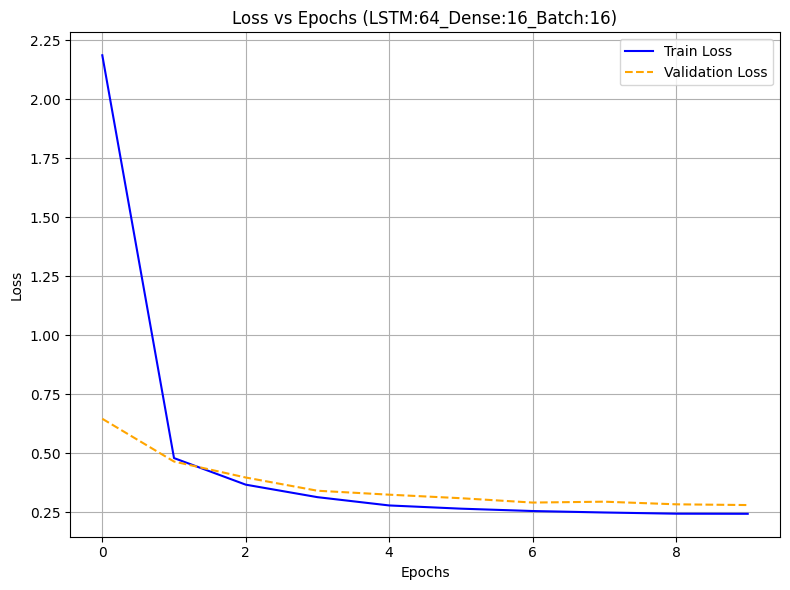

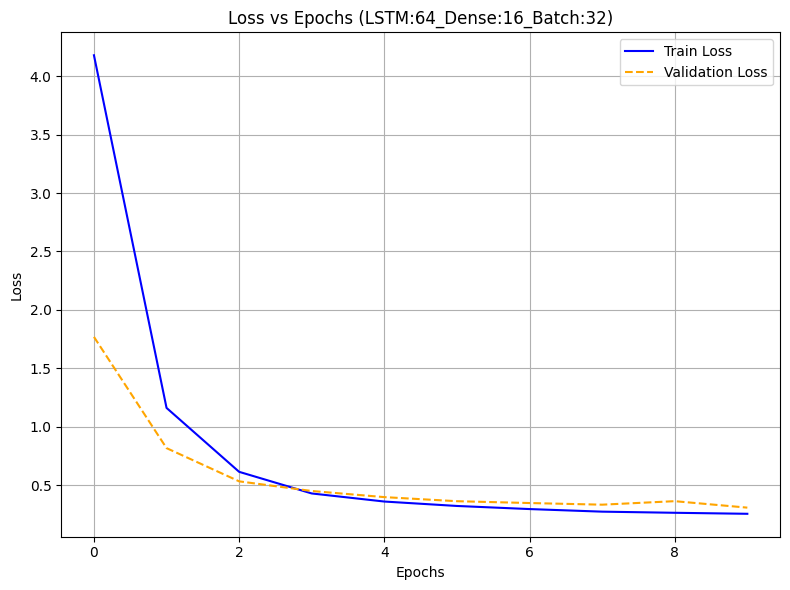

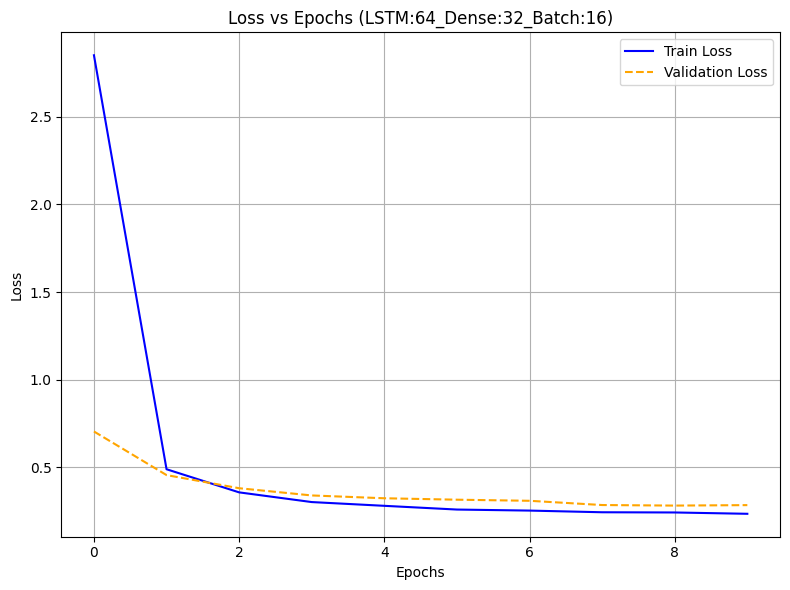

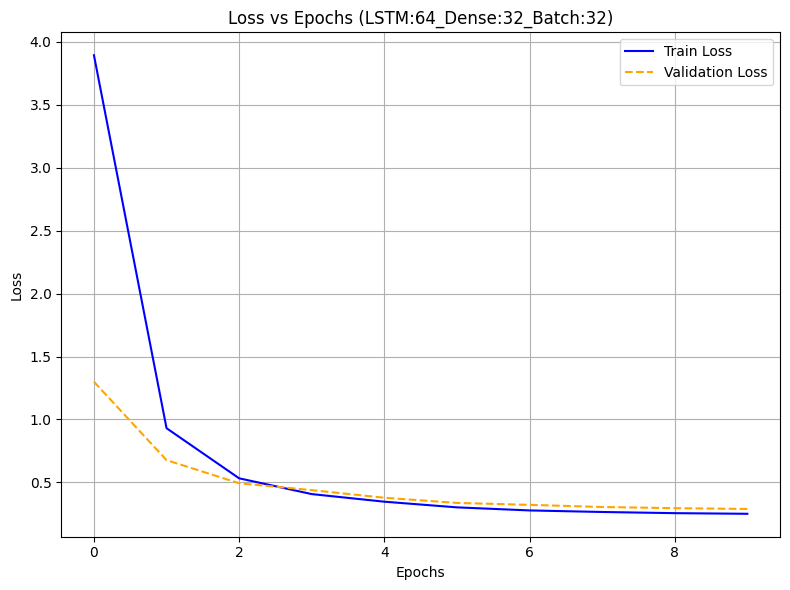

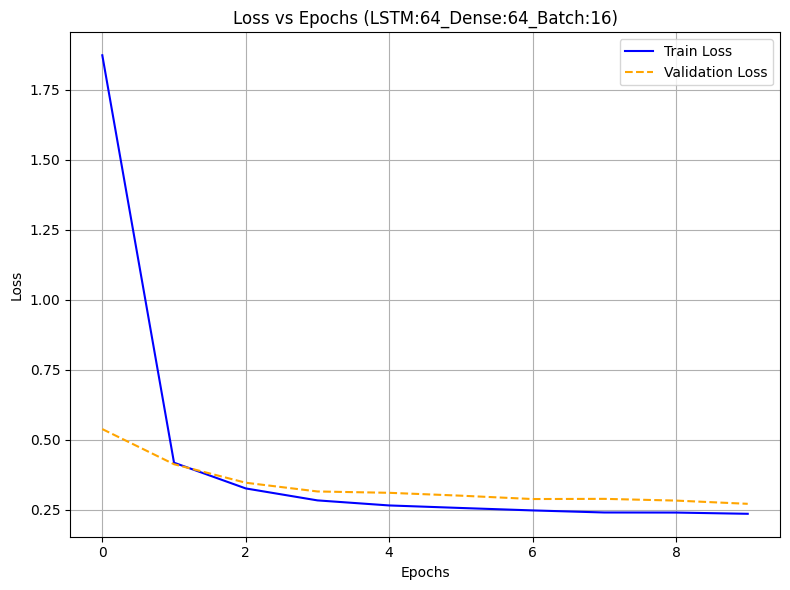

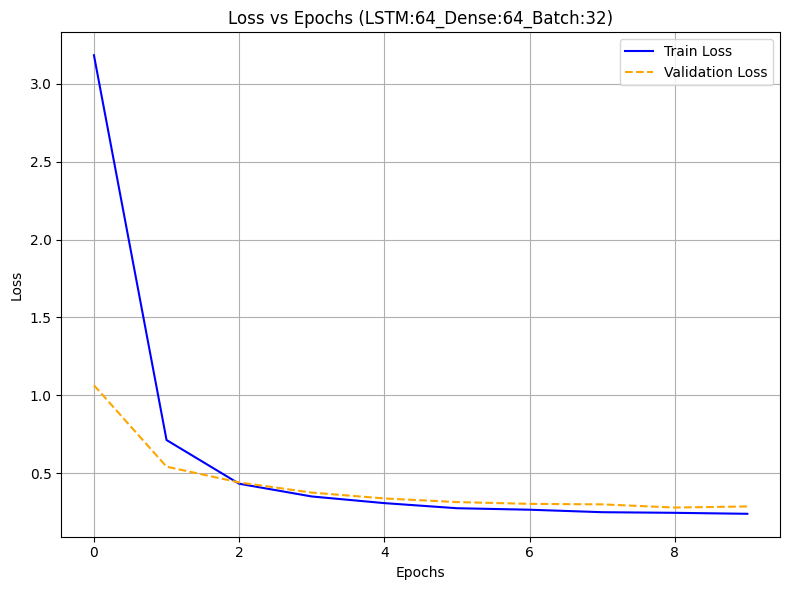

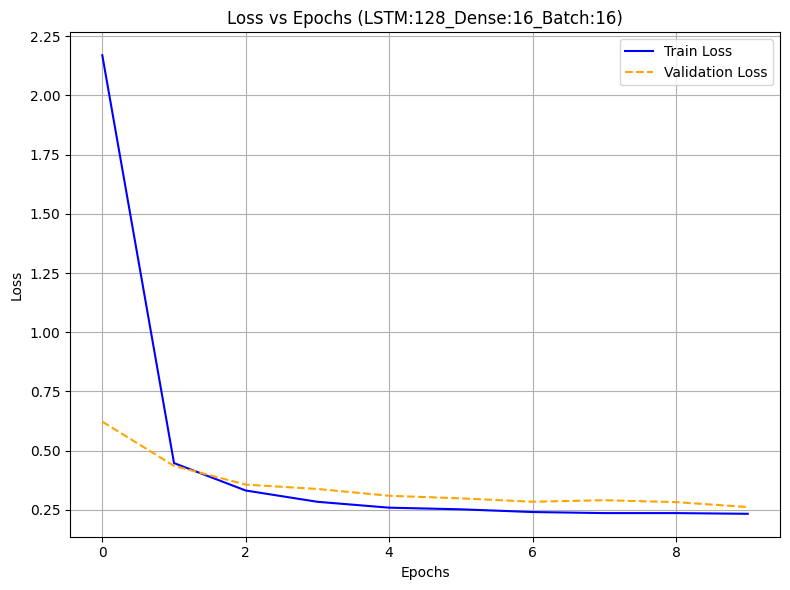

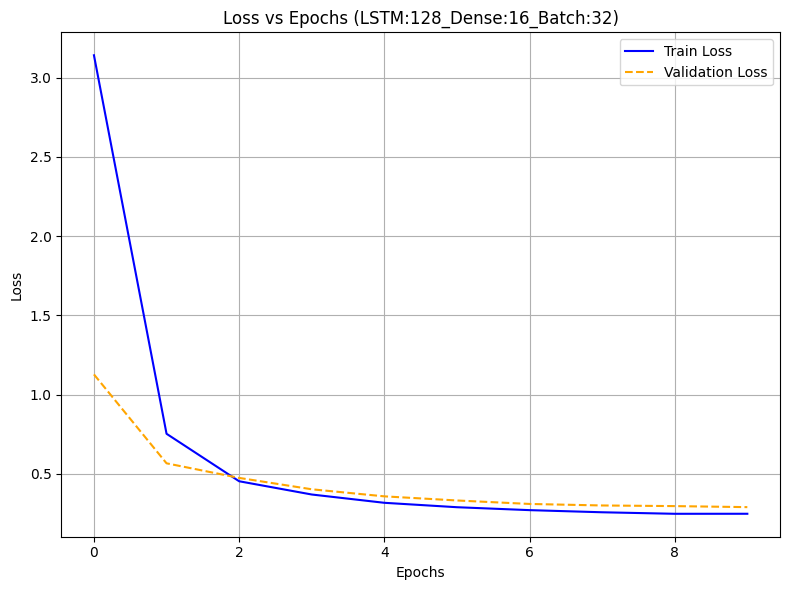

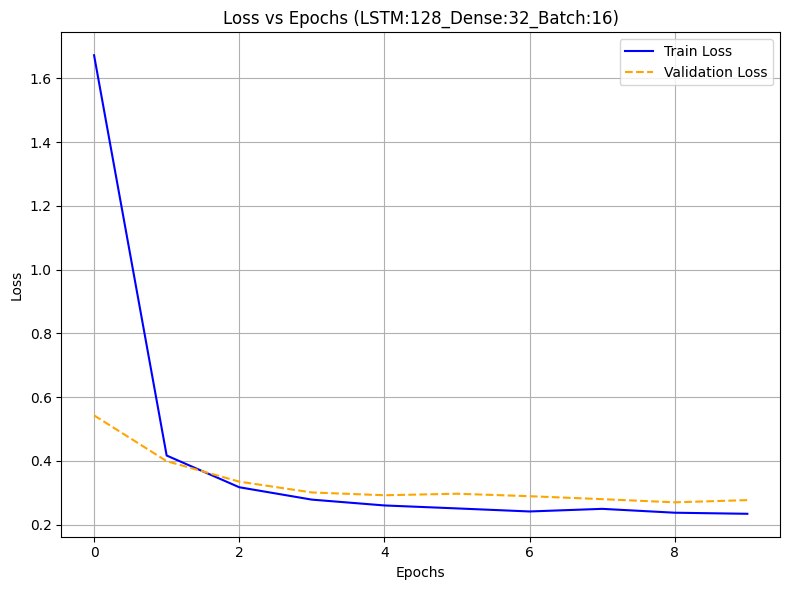

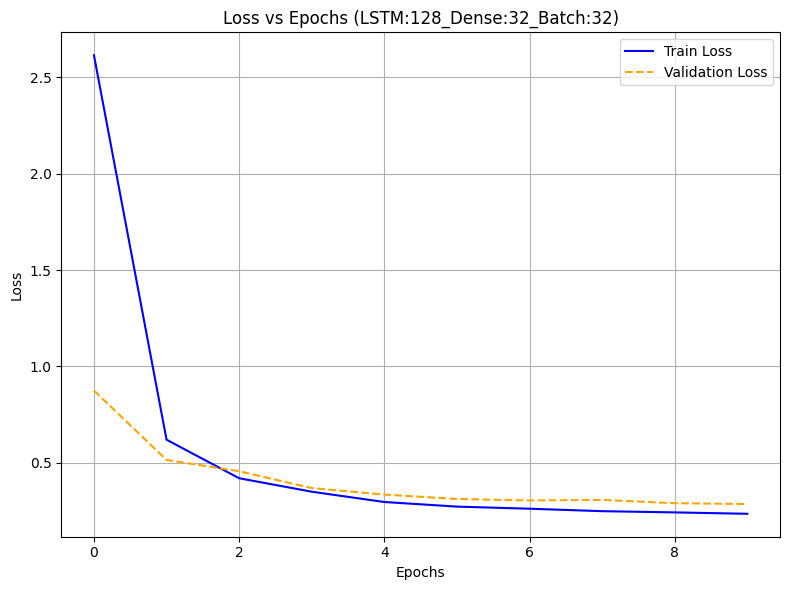

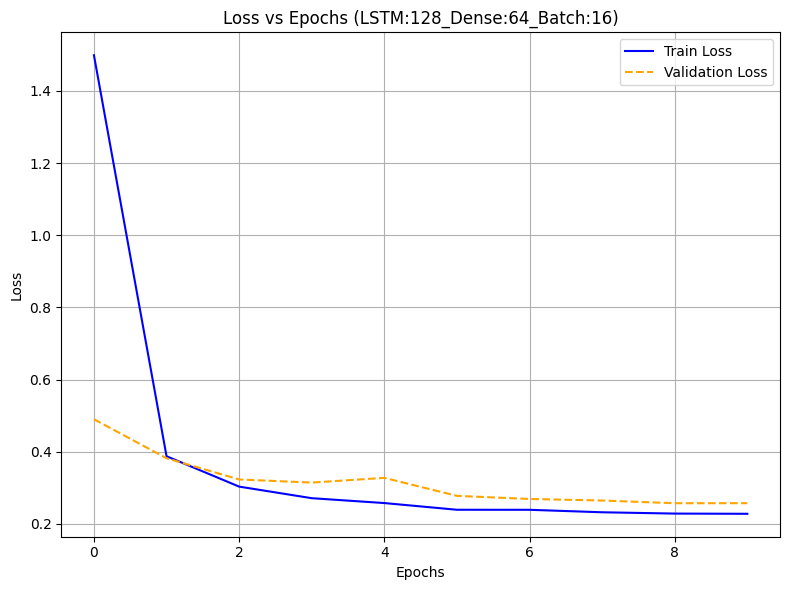

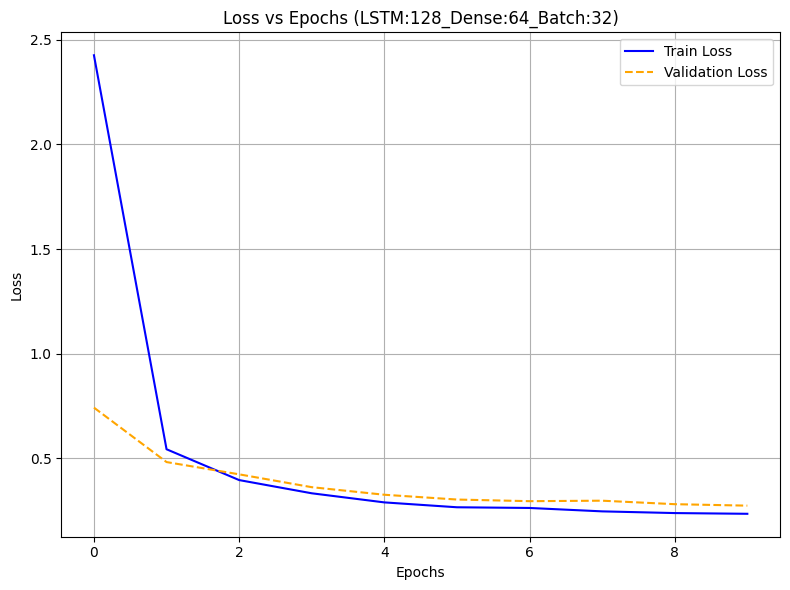

In [6]:
import matplotlib.pyplot as plt

# Plot separate graphs for each combination
for key, hist in history_dict.items():
    plt.figure(figsize=(8, 6))
    plt.plot(hist['loss'], label='Train Loss', color='blue')
    plt.plot(hist['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    plt.title(f'Loss vs Epochs ({key})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error


param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}


xgb_model = XGBRegressor(random_state=42)

# Define the scoring metric and the randomized search
scorer = make_scorer(mean_squared_error, greater_is_better=False)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)


best_xgb_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)


xgb_predictions = best_xgb_model.predict(X_test)


mse = mean_squared_error(y_test, xgb_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, xgb_predictions)
r2 = r2_score(y_test, xgb_predictions)

print(f'Tuned XGBoost Model Metrics:')
print(f'  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')




Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Tuned XGBoost Model Metrics:
  MSE: 0.1038, RMSE: 0.3221, MAE: 0.1677, R²: 0.9552


In [ ]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
lgbm_predictions = model.predict(X_test)


mse = mean_squared_error(y_test, lgbm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lgbm_predictions)
r2 = r2_score(y_test, lgbm_predictions)

print(f'LightGBM Model Metrics:')
print(f'  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 3212, number of used features: 6
[LightGBM] [Info] Start training from score 1.903420
LightGBM Model Metrics:
  MSE: 0.1106, RMSE: 0.3326, MAE: 0.1734, R²: 0.9522
